In [614]:
import numpy as np
import pandas as pd
from scipy import signal, optimize
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
dfh264 = pd.read_csv('h.264+mp3_TS_hc.csv')
dfh265 = pd.read_csv('h.265+mp3_hc.csv')

df3_state = pd.read_csv('x12_3state.csv')
df2_state = pd.read_csv('df_04dec_2state.csv')
dfconstant = pd.read_csv('client1_const.csv')

In [3]:
Time = np.arange(0,len(dfh265))

In [4]:
#Extracting values for 3 state df
a = df3_state["Jitter"][:1280].values
b = df3_state["Jitter"][26000:27279].values
c = df3_state["Jitter"][72000:73279].values
d = np.concatenate((a,b,c))

#Extracting values for 2 state df
a1 = df2_state["Jitter"][:960].values
b1 = df2_state["Jitter"][1800:2760].values
c1 = df2_state["Jitter"][3000:3959].values
d1 = df2_state["Jitter"][4000:4959].values
e1 = np.concatenate((a1,b1,c1,d1))

In [5]:
df = pd.DataFrame()

df['Time'] = Time
df['df265_hc'] = dfh265["Jitter"].values
df['df264_hc'] = dfh264["Jitter"][:3838].values
df['const_j'] = dfconstant["Jitter"][:3838].values
df['3_state'] = d
df['2_state'] = e1


df = df.set_index('Time')
df.index.freq = 'ms'
df.head()

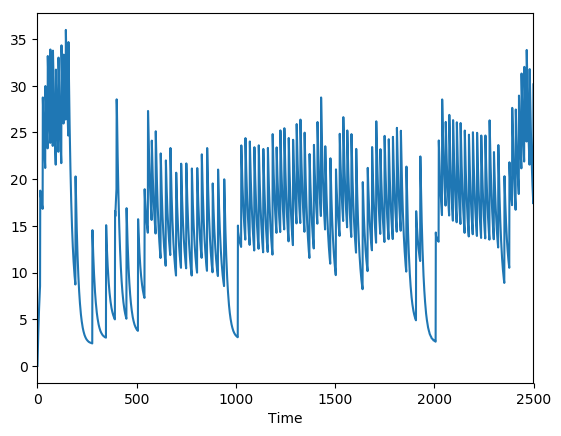

In [615]:
df['const_j'][:2500].plot()


In [13]:
df.head()

df265_hc  df264_hc   const_j    3_state   2_state
Time                                                   
0     0.000000  0.000000  0.000000  27.209970  0.000000
1     2.006083  0.594313  1.006188  25.934528  1.006188
2     3.905668  1.178605  1.883579  24.721113  1.883579
3     5.684779  1.684005  2.694827  23.604161  2.694827
4     6.809314  2.197755  3.467310  22.542144  3.467310

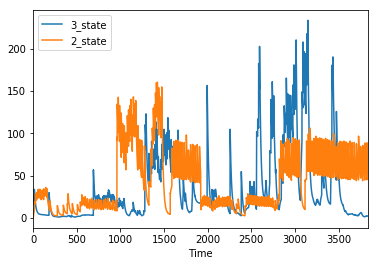

In [15]:
df[['3_state', '2_state']].plot()

In [17]:
df.describe()

df265_hc     df264_hc      const_j      3_state      2_state
count  3838.000000  3838.000000  3838.000000  3838.000000  3838.000000
mean    125.875043   107.350070    16.073229    34.605448    41.821012
std     115.098744   111.186312     6.836963    41.310407    32.929310
min       0.000000     0.000000     0.000000     0.980491     0.000000
25%      52.079810    27.605125    12.179808     5.311628    14.705559
50%      76.667788    66.492909    15.875724    17.981339    26.931445
75%     154.221348   147.562561    20.415158    47.938064    64.351811
max     749.556697   650.212032    37.875243   233.607401   160.374660

In [16]:
def func(x,a,b):
    return a*np.exp(b*x)

## 2 state

In [182]:
x2_a = df["2_state"][0:100].values
x2_b = df["2_state"][1200:1400].values

x2 = np.concatenate((x2_a,x2_b))

In [183]:
N2 = len(x2)
t2 = np.linspace(0,100,N2)

In [184]:
dx2dt = np.abs(np.diff(x2)/np.diff(t2))

In [188]:
xc2it = 20

In [189]:
q2 = np.where(dx2dt > xc2it)

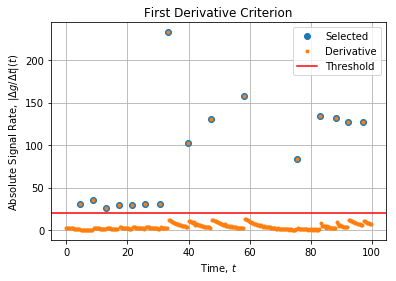

In [190]:
fig, axe = plt.subplots()
axe.plot(t2[q2[0]], dx2dt[q2[0]], 'o', label='Selected')
axe.plot(t2[:-1], dx2dt, '.', label='Derivative')
axe.axhline(xc2it, color="red", label='Threshold')
axe.set_title("First Derivative Criterion")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Absolute Signal Rate, $|\Delta g/\Delta t|(t)$")
axe.legend()
axe.grid()

In [192]:
idx2 = [0] + list(q2[0]+1) + [t2.size]
#idx2

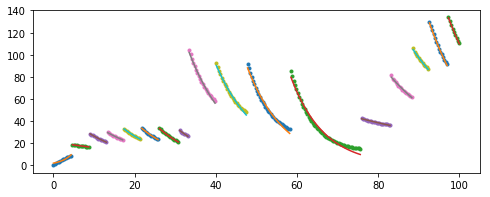

In [512]:
trials2 = []
fig, axe = plt.subplots(figsize=(8,3))
for k, (i, j) in enumerate(zip(idx2[:-1], idx2[1:])):
    p, s = optimize.curve_fit(func, t2[i:j]-t2[i], x2[i:j])
    axe.plot(t2[i:j], x2[i:j], '.', label="Data #{}".format(k+1))
    axe.plot(t2[i:j], func(t2[i:j]-t2[i], *p), label="Curve Fit #{}".format(k+1))
    trials2.append({"n0": i, "n1": j, "t0": t2[i], "a": p[0], "b": p[1],
                   "s_a": s[0,0], "s_b": s[1,1], "s_ab": s[0,1]})
#axe.set_title("Curve Fits")
#axe.set_xlabel("Time, $t$")
#axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
#axe.axes.yaxis.set_ticks([])
#axe.legend()
#fig.tight_layout()
#fig.savefig('model.pdf', format='pdf', dpi=1500);
#axe.grid()

In [363]:
df2 = pd.DataFrame(trials2)
df2

a         b   n0   n1       s_a      s_ab           s_b  \
0     2.020787  0.357654    0   14  0.090331 -0.012343  1.861761e-03   
1    18.657350 -0.027312   14   27  0.001296 -0.000025  7.088235e-07   
2    28.486321 -0.076750   27   40  0.007971 -0.000106  2.109077e-06   
3    29.601497 -0.068146   40   52  0.011622 -0.000160  3.263419e-06   
4    32.908656 -0.083001   52   65  0.010318 -0.000120  2.078028e-06   
5    33.580086 -0.091634   65   78  0.011513 -0.000132  2.276611e-06   
6    33.400271 -0.097662   78   93  0.016003 -0.000162  2.493304e-06   
7    31.574884 -0.090812   93  100  0.005232 -0.000118  4.055465e-06   
8   102.007148 -0.093639  100  120  0.353961 -0.000895  3.512106e-06   
9    90.207128 -0.092977  120  143  0.393305 -0.000994  3.942591e-06   
10   88.078419 -0.107418  143  175  0.726882 -0.001485  5.114021e-06   
11   79.529105 -0.122426  175  227  1.283809 -0.002302  7.887506e-06   
12   42.172399 -0.022008  227  249  0.019261 -0.000098  7.004990e-07   
13   79.552372 -0.052118  249  265  0.128050 -0.000488  2.713601e-06   
14  104.528100 -0.050745  265  277  0.158863 -0.000613  3.439411e-06   
15  128.727736 -0.081642  277  291  0.180716 -0.000498  2.057740e-06   
16  133.399350 -0.072507  291  300  0.063819 -0.000261  1.592865e-06   

           t0  
0    0.000000  
1    4.682274  
2    9.030100  
3   13.377926  
4   17.391304  
5   21.739130  
6   26.086957  
7   31.103679  
8   33.444816  
9   40.133779  
10  47.826087  
11  58.528428  
12  75.919732  
13  83.277592  
14  88.628763  
15  92.642140  
16  97.324415

## Test data - 2 state

In [497]:
#test data
x2_ta = df["2_state"][0:200].values
x2_tb = df["2_state"][1400:150].values

x2t = np.concatenate((x2_ta,x2_tb))

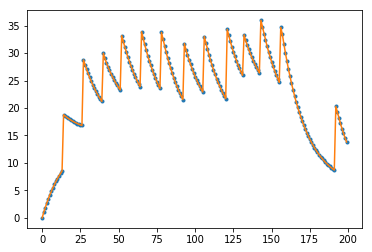

In [498]:
plt.plot(x2t, '.')
plt.plot(x2t, '-')

In [499]:
N2t = len(x2t)
t2t = np.linspace(0,100,N2t)

In [500]:
dx2tdt = np.abs(np.diff(x2t)/np.diff(t2t))

In [507]:
xc2tit = 4

In [508]:
q2t = np.where(dx2tdt > xc2tit)

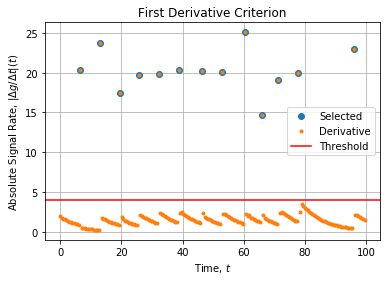

In [509]:
fig, axe = plt.subplots()
axe.plot(t2t[q2t[0]], dx2tdt[q2t[0]], 'o', label='Selected')
axe.plot(t2t[:-1], dx2tdt, '.', label='Derivative')
axe.axhline(xc2tit, color="red", label='Threshold')
axe.set_title("First Derivative Criterion")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Absolute Signal Rate, $|\Delta g/\Delta t|(t)$")
axe.legend()
axe.grid()

In [510]:
idx2t = [0] + list(q2t[0]+1) + [t2t.size]
idx2t

[0, 14, 27, 40, 52, 65, 78, 93, 106, 121, 132, 143, 156, 192, 200]

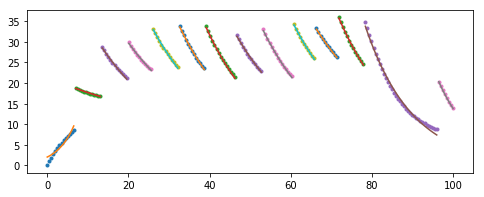

In [513]:
trials2t = []
fig, axe = plt.subplots(figsize=(8,3))
for k, (i, j) in enumerate(zip(idx2t[:-1], idx2t[1:])):
    p, s = optimize.curve_fit(func, t2t[i:j]-t2t[i], x2t[i:j])
    axe.plot(t2t[i:j], x2t[i:j], '.', label="Data #{}".format(k+1))
    axe.plot(t2t[i:j], func(t2t[i:j]-t2t[i], *p), label="Curve Fit #{}".format(k+1))
    trials2t.append({"n0": i, "n1": j, "t0": t2t[i], "a": p[0], "b": p[1],
                   "s_a": s[0,0], "s_b": s[1,1], "s_ab": s[0,1]})

In [514]:
df2t = pd.DataFrame(trials2t)

In [515]:
df2t

a         b   n0   n1       s_a      s_ab           s_b         t0
0    2.020787  0.238037    0   14  0.090331 -0.008215  8.246852e-04   0.000000
1   18.657350 -0.018178   14   27  0.001296 -0.000017  3.139800e-07   7.035176
2   28.486321 -0.051081   27   40  0.007971 -0.000071  9.342353e-07  13.567839
3   29.601497 -0.045355   40   52  0.011622 -0.000107  1.445562e-06  20.100503
4   32.908656 -0.055241   52   65  0.010318 -0.000080  9.204817e-07  26.130653
5   33.580086 -0.060987   65   78  0.011513 -0.000088  1.008446e-06  32.663317
6   33.400271 -0.064999   78   93  0.016003 -0.000108  1.104432e-06  39.195980
7   31.320741 -0.054016   93  106  0.013603 -0.000110  1.333493e-06  46.733668
8   32.655432 -0.060739  106  121  0.016642 -0.000114  1.178596e-06  53.266332
9   34.063519 -0.056084  121  132  0.010708 -0.000094  1.237867e-06  60.804020
10  33.030143 -0.046309  132  143  0.008941 -0.000080  1.065867e-06  66.331658
11  35.747946 -0.063646  143  156  0.010659 -0.000076  8.322991e-07  71.859296
12  33.747756 -0.086397  156  192  0.091862 -0.000321  2.019916e-06  78.391960
13  20.312566 -0.109893  192  200  0.000221 -0.000005  1.556946e-07  96.482412

In [526]:
#df2t.drop(columns=['s_a', 's_ab', 's_b', 't0'], axis=1,inplace=True)
#df2t

In [528]:
df2t['n1'] - df2t['n0']

0     14
1     13
2     13
3     12
4     13
5     13
6     15
7     13
8     15
9     11
10    11
11    13
12    36
13     8
dtype: int64

In [529]:
df2t['periods'] = df2t['n1'] - df2t['n0']

In [531]:
df2t.drop(columns=['n0','n1'], axis=1,inplace=True)

In [533]:
df2t['src'] = 'df2'

In [534]:
df2t.head()

a         b  periods  src
0   2.020787  0.238037       14  df2
1  18.657350 -0.018178       13  df2
2  28.486321 -0.051081       13  df2
3  29.601497 -0.045355       12  df2
4  32.908656 -0.055241       13  df2

In [535]:
x2_test = df2t.drop(columns=['src'], axis=1)
x2_test.head()

a         b  periods
0   2.020787  0.238037       14
1  18.657350 -0.018178       13
2  28.486321 -0.051081       13
3  29.601497 -0.045355       12
4  32.908656 -0.055241       13

In [536]:
x2_test['b'] = abs(x2_test['b'])
x2_test.head()

a         b  periods
0   2.020787  0.238037       14
1  18.657350  0.018178       13
2  28.486321  0.051081       13
3  29.601497  0.045355       12
4  32.908656  0.055241       13

In [537]:
preds_x2_test = dtree.predict(x2_test)

In [538]:
preds_x2_test

array(['df2', 'df2', 'df2', 'df2', 'df3', 'df3', 'df3', 'df3', 'df3',
       'df3', 'df2', 'df3', 'df2', 'dfc'], dtype=object)

In [539]:
print(confusion_matrix(df2t['src'],preds_x2_test))

[[6 7 1]
 [0 0 0]
 [0 0 0]]


In [540]:
from sklearn.metrics import accuracy_score

In [541]:
print ("Accuracy : ", 
    accuracy_score(df2t['src'],preds_x2_test)*100) 

Accuracy :  42.857142857142854


In [564]:
preds_rfc_x2_test = rfc.predict(x2_test)

In [565]:
print ("Accuracy : ", 
    accuracy_score(df2t['src'],preds_rfc_x2_test)*100) 

Accuracy :  85.71428571428571


In [566]:
print(confusion_matrix(df2t['src'],preds_rfc_x2_test))

[[12  2]
 [ 0  0]]


In [562]:
preds_rfc_x2_test

array(['df2', 'df2', 'df2', 'df3', 'df3', 'df3', 'df3', 'df3', 'df3',
       'df3', 'df3', 'df3', 'df2', 'dfc'], dtype=object)

In [548]:
print(classification_report(df2t['src'],preds_rfc_x2_test))

              precision    recall  f1-score   support

         df2       1.00      0.86      0.92        14
         df3       0.00      0.00      0.00         0

   micro avg       0.86      0.86      0.86        14
   macro avg       0.50      0.43      0.46        14
weighted avg       1.00      0.86      0.92        14



C:\Users\obinna.izima\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\obinna.izima\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\obinna.izima\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [550]:
df2t['rfc'] = preds_rfc_x2_test
df2t['dt'] = preds_x2_test
df2t

a         b  periods  src  rfc   dt
0    2.020787  0.238037       14  df2  df2  df2
1   18.657350 -0.018178       13  df2  df2  df2
2   28.486321 -0.051081       13  df2  df2  df2
3   29.601497 -0.045355       12  df2  df2  df2
4   32.908656 -0.055241       13  df2  df2  df3
5   33.580086 -0.060987       13  df2  df2  df3
6   33.400271 -0.064999       15  df2  df2  df3
7   31.320741 -0.054016       13  df2  df2  df3
8   32.655432 -0.060739       15  df2  df2  df3
9   34.063519 -0.056084       11  df2  df3  df3
10  33.030143 -0.046309       11  df2  df3  df2
11  35.747946 -0.063646       13  df2  df2  df3
12  33.747756 -0.086397       36  df2  df2  df2
13  20.312566 -0.109893        8  df2  df2  dfc

## 3 state

In [335]:
x3_a = df["3_state"][0:50].values
x3_b = df["3_state"][1400:1450].values
x3_c = df["3_state"][2700:2750].values

x3 = np.concatenate((x3_a,x3_b,x3_c))

In [336]:
N3 = len(x3)
t3 = np.linspace(0,100,N3)

In [337]:
dx3dt = np.abs(np.diff(x3)/np.diff(t3))

In [341]:
xc3it = 15

In [342]:
q3 = np.where(dx3dt > xc3it)
q3

(array([ 12,  49,  55,  66,  83,  99, 111, 124, 139], dtype=int64),)

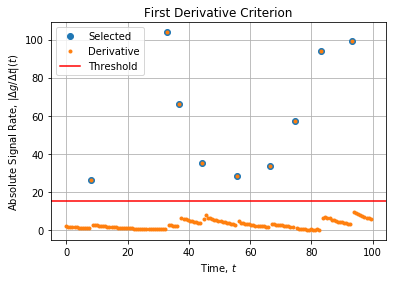

In [343]:
fig, axe = plt.subplots()
axe.plot(t3[q3[0]], dx3dt[q3[0]], 'o', label='Selected')
axe.plot(t3[:-1], dx3dt, '.', label='Derivative')
axe.axhline(xc3it, color="red", label='Threshold')
axe.set_title("First Derivative Criterion")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Absolute Signal Rate, $|\Delta g/\Delta t|(t)$")
axe.legend()
axe.grid()

In [344]:
idx3 = [0] + list(q3[0]+1) + [t3.size]

Text(0, 0.5, 'Jitter Estimate, $\\hat{j_t}(ms)$')

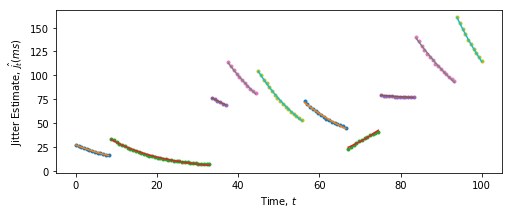

In [345]:
trials3 = []
fig, axe = plt.subplots(figsize=(8,3))
for k, (i, j) in enumerate(zip(idx3[:-1], idx3[1:])):
    p, s = optimize.curve_fit(func, t3[i:j]-t3[i], x3[i:j])
    axe.plot(t3[i:j], x3[i:j], '.', label="Data #{}".format(k+1))
    axe.plot(t3[i:j], func(t3[i:j]-t3[i], *p), label="Curve Fit #{}".format(k+1))
    trials3.append({"n0": i, "n1": j, "t0": t3[i], "a": p[0], "b": p[1],
                   "s_a": s[0,0], "s_b": s[1,1], "s_ab": s[0,1]})
#axe.set_title("Curve Fits")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
#axe.axes.yaxis.set_ticks([])
#axe.legend()
#fig.tight_layout()
#fig.savefig('model.pdf', format='pdf', dpi=1500);
#axe.grid()

In [362]:
df3 = pd.DataFrame(trials3)
df3

a         b   n0   n1       s_a      s_ab           s_b         t0
0   26.999424 -0.065163    0   13  0.006108 -0.000045  5.140758e-07   0.000000
1   32.726914 -0.072728   13   50  0.061677 -0.000173  9.007184e-07   8.724832
2   76.298171 -0.029822   50   56  0.006802 -0.000037  3.020514e-07  33.557047
3  112.752541 -0.050273   56   67  0.086522 -0.000174  5.303616e-07  37.583893
4  104.085403 -0.064078   67   84  0.126238 -0.000188  4.483342e-07  44.966443
5   71.303146 -0.047301   84  100  0.116561 -0.000258  8.729677e-07  56.375839
6   24.640280  0.073627  100  112  0.287577 -0.002090  1.899825e-05  67.114094
7   78.956605 -0.003674  112  125  0.010998 -0.000025  7.965191e-08  75.167785
8  138.585479 -0.042959  125  140  0.276446 -0.000331  6.003099e-07  83.892617
9  160.258661 -0.055729  140  150  0.105358 -0.000165  3.935266e-07  93.959732

## constant congestion

In [347]:
xc = df["const_j"][599:899].values

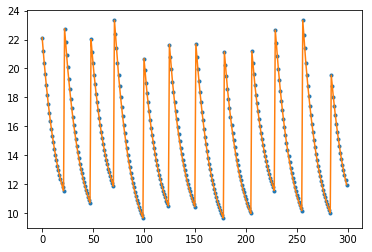

In [348]:
plt.plot(xc, '.')
plt.plot(xc, '-')

In [349]:
Nc = len(xc)
tc = np.linspace(0,100,Nc)

In [350]:
dxdt = np.abs(np.diff(xc)/np.diff(tc))

In [354]:
xit = 4.5

In [355]:
qc = np.where(dxdt > xit)
qc

(array([ 21,  47,  70,  99, 124, 150, 178, 205, 228, 255, 283], dtype=int64),)

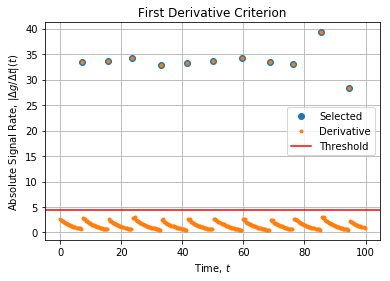

In [356]:
fig, axe = plt.subplots()
axe.plot(tc[qc[0]], dxdt[qc[0]], 'o', label='Selected')
axe.plot(tc[:-1], dxdt, '.', label='Derivative')
axe.axhline(xit, color="red", label='Threshold')
axe.set_title("First Derivative Criterion")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Absolute Signal Rate, $|\Delta g/\Delta t|(t)$")
axe.legend()
axe.grid()

In [357]:
idxc = [0] + list(qc[0]+1) + [tc.size]
idxc

[0, 22, 48, 71, 100, 125, 151, 179, 206, 229, 256, 284, 300]

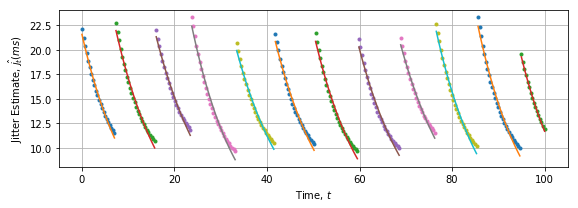

In [358]:
trials_c = []
fig, axe = plt.subplots(figsize=(8,3))
for k, (i, j) in enumerate(zip(idxc[:-1], idxc[1:])):
    p, s = optimize.curve_fit(func, tc[i:j]-tc[i], xc[i:j])
    axe.plot(tc[i:j], xc[i:j], '.', label="Data #{}".format(k+1))
    #axe.plot(tc[i:j], xc[i:j], '.', label=".")
    axe.plot(tc[i:j], func(tc[i:j]-tc[i], *p), label="Curve Fit #{}".format(k+1))
    #axe.plot(tc[i:j], func(tc[i:j]-tc[i], *p), label="-")
    trials_c.append({"n0": i, "n1": j, "t0": tc[i], "a": p[0], "b": p[1],
                   "s_a": s[0,0], "s_b": s[1,1], "s_ab": s[0,1]})
#axe.set_title("Curve Fits")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
#axe.axes.yaxis.set_tickbs([])
#axe.legend()
fig.tight_layout()
#fig.savefig('model.pdf', format='pdf', dpi=1500);

axe.yaxis.grid(True)
axe.xaxis.grid(True)

In [361]:
dfc = pd.DataFrame(trials_c)
dfc

a         b   n0   n1       s_a      s_ab       s_b         t0
0   21.561409 -0.095519    0   22  0.020127 -0.000222  0.000004   0.000000
1   21.949964 -0.093986   22   48  0.032863 -0.000308  0.000005   7.357860
2   21.322797 -0.086482   48   71  0.023988 -0.000254  0.000004  16.053512
3   22.389210 -0.099620   71  100  0.044597 -0.000379  0.000005  23.745819
4   19.926287 -0.087508  100  125  0.026466 -0.000279  0.000005  33.444816
5   20.836090 -0.090690  125  151  0.031863 -0.000313  0.000005  41.806020
6   20.853419 -0.094218  151  179  0.034279 -0.000318  0.000005  50.501672
7   20.281684 -0.090202  179  206  0.033267 -0.000324  0.000005  59.866221
8   20.504680 -0.084624  206  229  0.023847 -0.000261  0.000004  68.896321
9   21.874439 -0.096785  229  256  0.033484 -0.000307  0.000005  76.588629
10  22.383298 -0.098532  256  284  0.041873 -0.000365  0.000005  85.618729
11  19.269903 -0.099379  284  300  0.006680 -0.000110  0.000003  94.983278

## h.264 highly congested route

In [63]:
df.columns

Index(['df265_hc', 'df264_hc', 'const_j', '3_state', '2_state'], dtype='object')

In [195]:
xr = df['df264_hc'][:400].values

In [196]:
N = len(xr)
t = np.linspace(0,100,N)

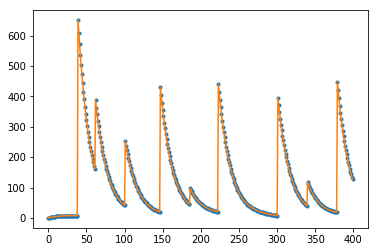

In [197]:
plt.plot(xr, '.')
plt.plot(xr, '-')

In [198]:
dxrdt = np.abs(np.diff(xr)/np.diff(t))

In [219]:
xcrit = 165

In [220]:
q = np.where(dxrdt > xcrit)
q

(array([ 38,  61, 100, 146, 185, 222, 300, 339, 378], dtype=int64),)

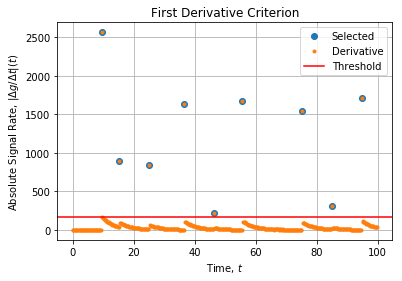

In [221]:
fig, axe = plt.subplots()
axe.plot(t[q[0]], dxrdt[q[0]], 'o', label='Selected')
axe.plot(t[:-1], dxrdt, '.', label='Derivative')
axe.axhline(xcrit, color="red", label='Threshold')
axe.set_title("First Derivative Criterion")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Absolute Signal Rate, $|\Delta g/\Delta t|(t)$")
axe.legend()
axe.grid()

In [222]:
idx = [0] + list(q[0]+1) + [t.size]
idx

[0, 39, 62, 101, 147, 186, 223, 301, 340, 379, 400]

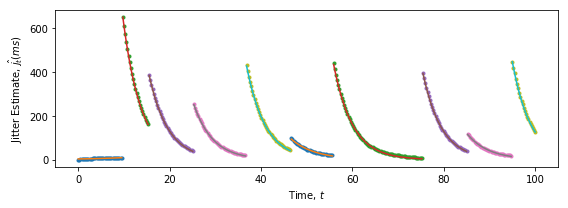

In [223]:
trials = []
fig, axe = plt.subplots(figsize=(8,3))
for k, (i, j) in enumerate(zip(idx[:-1], idx[1:])):
    p, s = optimize.curve_fit(func, t[i:j]-t[i], xr[i:j])
    axe.plot(t[i:j], xr[i:j], '.', label="Data #{}".format(k+1))
    axe.plot(t[i:j], func(t[i:j]-t[i], *p), label="Curve Fit #{}".format(k+1))
    trials.append({"n0": i, "n1": j, "t0": t[i], "a": p[0], "b": p[1],
                   "s_a": s[0,0], "s_b": s[1,1], "s_ab": s[0,1]})
#axe.set_title("Curve Fits")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
#axe.axes.yaxis.set_ticks([])
#axe.legend()
fig.tight_layout()
#fig.savefig('model.pdf', format='pdf', dpi=1500);
#axe.grid()

In [360]:
df_hc = pd.DataFrame(trials)
df_hc

a         b   n0   n1       s_a      s_ab           s_b         t0
0    3.283752  0.106452    0   39  0.084386 -0.003488  1.674217e-04   0.000000
1  649.378018 -0.253810   39   62  0.065015 -0.000036  3.671004e-08   9.774436
2  383.561042 -0.242375   62  101  0.669653 -0.000473  6.658784e-07  15.538847
3  250.794381 -0.238677  101  147  0.531931 -0.000541  1.121209e-06  25.313283
4  426.972647 -0.245024  147  186  0.601005 -0.000384  4.904363e-07  36.842105
5   93.909304 -0.190807  186  223  0.664365 -0.001718  8.243209e-06  46.616541
6  434.102815 -0.242035  223  301  2.486504 -0.001390  1.648905e-06  55.889724
7  392.934496 -0.245545  301  340  0.200070 -0.000139  1.934098e-07  75.438596
8  114.820746 -0.213777  340  379  0.702132 -0.001536  6.482371e-06  85.213033
9  446.557996 -0.252874  379  400  0.047409 -0.000041  6.257495e-08  94.987469

## create new dataset and run DT

In [87]:
abs(df2['b'].values)

array([0.23803727, 0.01817768, 0.05108124, 0.04535489, 0.0552413 ,
       0.06098693, 0.0649994 , 0.0604404 , 0.06232168, 0.06188113,
       0.07149246, 0.09648435])

In [475]:
data = df2, df3, dfc, df_hc

In [116]:
#print(data[3]['a'], data[3]['b'],data[3]['n1'] - ['n0'])

In [476]:
#print(data[3]['n1'] - data[3]['n0'])

In [477]:
#data[3]

In [137]:
df_new = pd.DataFrame()

In [478]:
num = np.arange(4)
df_src = ['df2','df3','dfc','df_hc']

In [135]:
"""for i in num:
    df_new['amp'] = data[i]['a']
    df_new['decay'] = data[i]['b']
    df_new['period'] = data[i]['n1'] - data[i]['n0']"""
    

In [366]:
#extract amp and decay

amp = np.concatenate((data[0]['a'].values,  data[1]['a'].values,  data[2]['a'].values,  data[3]['a'].values))
decay = np.concatenate((data[0]['b'].values,  data[1]['b'].values,  data[2]['b'].values,  data[3]['b'].values))

In [368]:
#decay

array([ 0.35765409, -0.0273122 , -0.07675021, -0.0681463 , -0.08300075,
       -0.09163363, -0.09766241, -0.09081246, -0.09363911, -0.09297719,
       -0.10741832, -0.12242604, -0.02200779, -0.05211827, -0.05074531,
       -0.0816422 , -0.07250665, -0.06516253, -0.0727282 , -0.02982238,
       -0.0502727 , -0.06407795, -0.04730067,  0.07362703, -0.00367387,
       -0.04295933, -0.05572913, -0.0955191 , -0.09398592, -0.08648164,
       -0.09962027, -0.08750842, -0.09068957, -0.094218  , -0.09020227,
       -0.08462415, -0.09678546, -0.09853243, -0.09937921,  0.10645172,
       -0.25381002, -0.24237543, -0.23867673, -0.24502377, -0.19080746,
       -0.24203491, -0.24554511, -0.21377733, -0.25287401])

In [370]:
#extract periods
period = []
for i in num:
    period.append(data[i]['n1'] - data[i]['n0'])

In [396]:
np.array(period[0][:])

array([14, 13, 13, 12, 13, 13, 15,  7, 20, 23, 32, 52, 22, 16, 12, 14,  9],
      dtype=int64)

In [399]:
p0 = np.array(period[0][:])
p1 = np.array(period[1][:])
p2 = np.array(period[2][:])
p3 = np.array(period[3][:])
periods = np.concatenate((p0,p1,p2,p3))
periods

array([14, 13, 13, 12, 13, 13, 15,  7, 20, 23, 32, 52, 22, 16, 12, 14,  9,
       13, 37,  6, 11, 17, 16, 12, 13, 15, 10, 22, 26, 23, 29, 25, 26, 28,
       27, 23, 27, 28, 16, 39, 23, 39, 46, 39, 37, 78, 39, 39, 21],
      dtype=int64)

In [401]:
len(periods)

49

In [405]:
len(p3)

10

In [408]:
df_new['amp'] = amp
df_new['decay'] = abs(decay)
df_new['periods'] = periods

In [410]:
df_new.tail()

amp     decay  periods
44   93.909304  0.190807       37
45  434.102815  0.242035       78
46  392.934496  0.245545       39
47  114.820746  0.213777       39
48  446.557996  0.252874       21

In [411]:
len(df_new)

49

In [413]:
for i in num:
    print(len(data[i]))

17
10
12
10


In [414]:
len(p0)

17

In [415]:
p0

array([14, 13, 13, 12, 13, 13, 15,  7, 20, 23, 32, 52, 22, 16, 12, 14,  9],
      dtype=int64)

In [416]:
p1

array([13, 37,  6, 11, 17, 16, 12, 13, 15, 10], dtype=int64)

In [417]:
p2

array([22, 26, 23, 29, 25, 26, 28, 27, 23, 27, 28, 16], dtype=int64)

In [418]:
p3

array([39, 23, 39, 46, 39, 37, 78, 39, 39, 21], dtype=int64)

In [422]:
dfsrc = np.arange(0,len(df_new))

In [424]:
dfsrc

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [438]:
df_new['src'] = ''

In [439]:
df_new['src'].iloc[:17] = df_src[0]
df_new['src'].iloc[17:27] = df_src[1]
df_new['src'].iloc[27:39] = df_src[2]
df_new['src'].iloc[39:49] = df_src[3]

C:\Users\obinna.izima\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [436]:
df_new['periods'].iloc[39:49]

39    39
40    23
41    39
42    46
43    39
44    37
45    78
46    39
47    39
48    21
Name: periods, dtype: int64

In [441]:
df_new

amp     decay  periods    src
0     2.020787  0.357654       14    df2
1    18.657350  0.027312       13    df2
2    28.486321  0.076750       13    df2
3    29.601497  0.068146       12    df2
4    32.908656  0.083001       13    df2
5    33.580086  0.091634       13    df2
6    33.400271  0.097662       15    df2
7    31.574884  0.090812        7    df2
8   102.007148  0.093639       20    df2
9    90.207128  0.092977       23    df2
10   88.078419  0.107418       32    df2
11   79.529105  0.122426       52    df2
12   42.172399  0.022008       22    df2
13   79.552372  0.052118       16    df2
14  104.528100  0.050745       12    df2
15  128.727736  0.081642       14    df2
16  133.399350  0.072507        9    df2
17   26.999424  0.065163       13    df3
18   32.726914  0.072728       37    df3
19   76.298171  0.029822        6    df3
20  112.752541  0.050273       11    df3
21  104.085403  0.064078       17    df3
22   71.303146  0.047301       16    df3
23   24.640280  0.073627       12    df3
24   78.956605  0.003674       13    df3
25  138.585479  0.042959       15    df3
26  160.258661  0.055729       10    df3
27   21.561409  0.095519       22    dfc
28   21.949964  0.093986       26    dfc
29   21.322797  0.086482       23    dfc
30   22.389210  0.099620       29    dfc
31   19.926287  0.087508       25    dfc
32   20.836090  0.090690       26    dfc
33   20.853419  0.094218       28    dfc
34   20.281684  0.090202       27    dfc
35   20.504680  0.084624       23    dfc
36   21.874439  0.096785       27    dfc
37   22.383298  0.098532       28    dfc
38   19.269903  0.099379       16    dfc
39    3.283752  0.106452       39  df_hc
40  649.378018  0.253810       23  df_hc
41  383.561042  0.242375       39  df_hc
42  250.794381  0.238677       46  df_hc
43  426.972647  0.245024       39  df_hc
44   93.909304  0.190807       37  df_hc
45  434.102815  0.242035       78  df_hc
46  392.934496  0.245545       39  df_hc
47  114.820746  0.213777       39  df_hc
48  446.557996  0.252874       21  df_hc

In [442]:
df_new.describe()

amp      decay    periods
count   49.000000  49.000000  49.000000
mean   108.867482   0.111076  23.469388
std    143.123797   0.076353  13.526366
min      2.020787   0.003674   6.000000
25%     21.949964   0.068146  13.000000
50%     42.172399   0.090812  22.000000
75%    112.752541   0.106452  28.000000
max    649.378018   0.357654  78.000000

In [443]:
import seaborn as sns

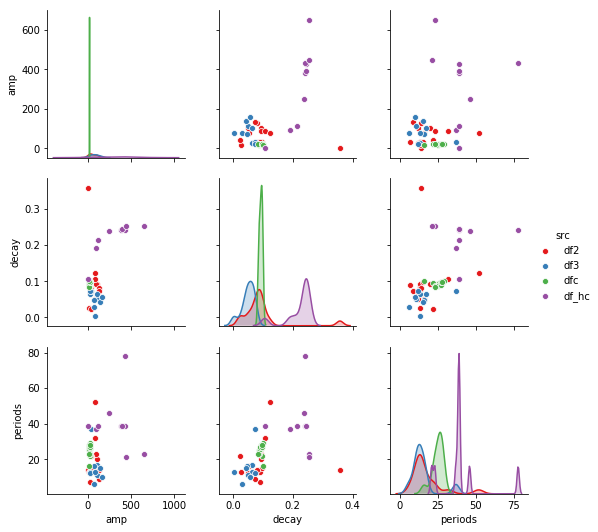

In [444]:
sns.pairplot(df_new,hue='src',palette='Set1')

In [554]:
X = df_new.drop('src',axis=1)
y = df_new['src']

In [446]:
from sklearn.tree import DecisionTreeClassifier

In [447]:
dtree = DecisionTreeClassifier()

In [448]:
dtree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [449]:
df_new.head()

amp     decay  periods  src
0   2.020787  0.357654       14  df2
1  18.657350  0.027312       13  df2
2  28.486321  0.076750       13  df2
3  29.601497  0.068146       12  df2
4  32.908656  0.083001       13  df2

In [451]:
df_new.loc[:5]

amp     decay  periods  src
0   2.020787  0.357654       14  df2
1  18.657350  0.027312       13  df2
2  28.486321  0.076750       13  df2
3  29.601497  0.068146       12  df2
4  32.908656  0.083001       13  df2
5  33.580086  0.091634       13  df2

In [452]:
xt = df_new.drop('src',axis=1).loc[:5]

In [457]:
xt1 = df_new.drop('src',axis=1).loc[23:30]

In [465]:
xt

amp     decay  periods
0   2.020787  0.357654       14
1  18.657350  0.027312       13
2  28.486321  0.076750       13
3  29.601497  0.068146       12
4  32.908656  0.083001       13
5  33.580086  0.091634       13

In [454]:
preds = dtree.predict(xt)

In [455]:
preds

array(['df2', 'df2', 'df2', 'df2', 'df2', 'df2'], dtype=object)

In [456]:
df_new.loc[23:30]

amp     decay  periods  src
23   24.640280  0.073627       12  df3
24   78.956605  0.003674       13  df3
25  138.585479  0.042959       15  df3
26  160.258661  0.055729       10  df3
27   21.561409  0.095519       22  dfc
28   21.949964  0.093986       26  dfc
29   21.322797  0.086482       23  dfc
30   22.389210  0.099620       29  dfc

In [458]:
preds1 = dtree.predict(xt1)

In [459]:
preds1

array(['df3', 'df3', 'df3', 'df3', 'dfc', 'dfc', 'dfc', 'dfc'],
      dtype=object)

In [460]:
from sklearn.metrics import classification_report,confusion_matrix

In [466]:
print(classification_report(y[:6],preds))

              precision    recall  f1-score   support

         df2       1.00      1.00      1.00         6

   micro avg       1.00      1.00      1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [467]:
print(confusion_matrix(y[:6],preds))

[[6]]


In [473]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

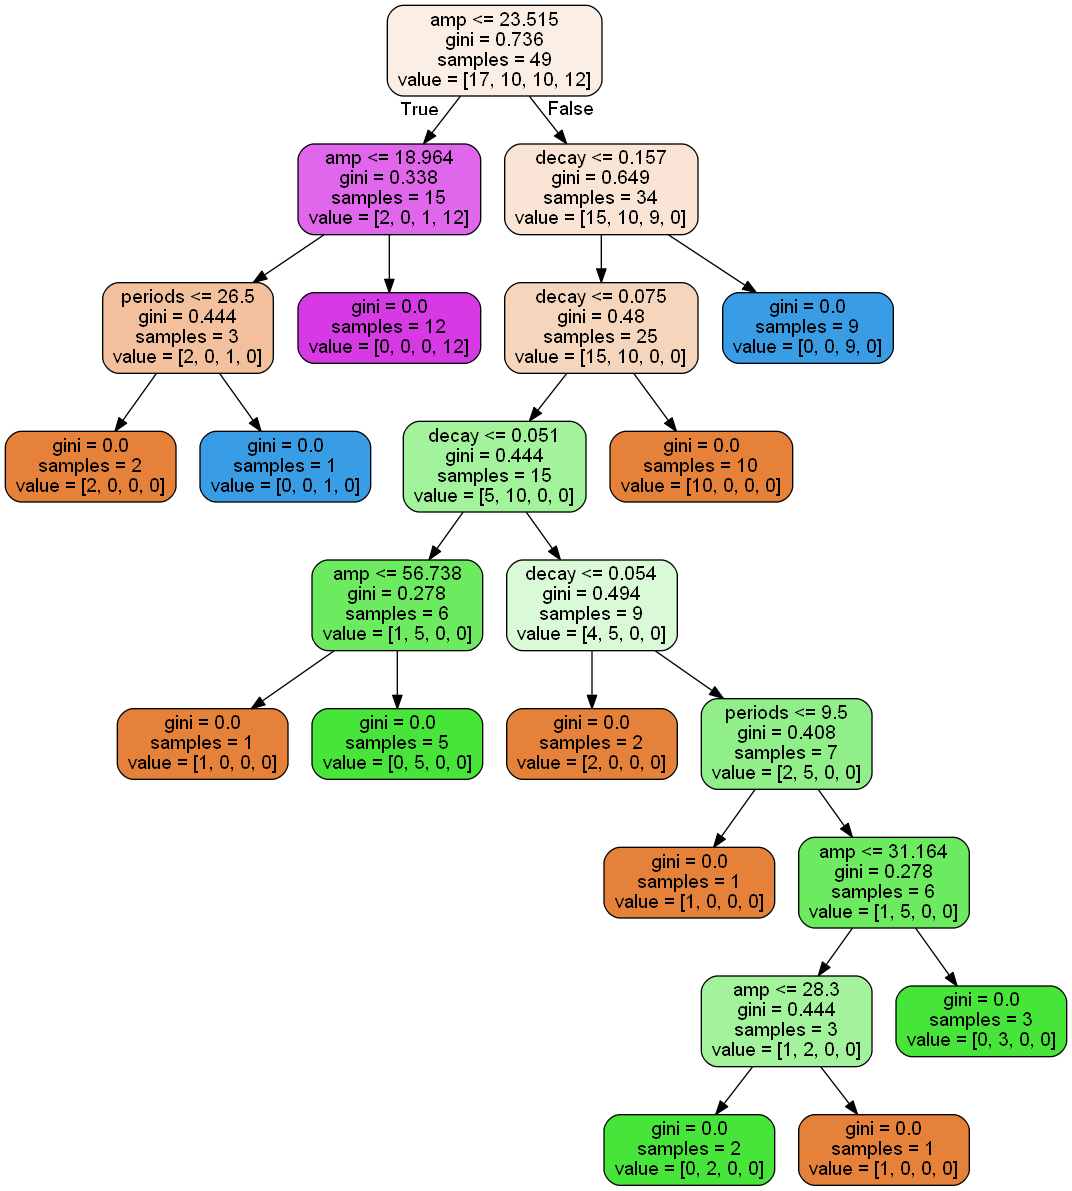

In [474]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=X.columns,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

'gini'

In [483]:
data[0]

a         b   n0   n1       s_a      s_ab           s_b  \
0     2.020787  0.357654    0   14  0.090331 -0.012343  1.861761e-03   
1    18.657350 -0.027312   14   27  0.001296 -0.000025  7.088235e-07   
2    28.486321 -0.076750   27   40  0.007971 -0.000106  2.109077e-06   
3    29.601497 -0.068146   40   52  0.011622 -0.000160  3.263419e-06   
4    32.908656 -0.083001   52   65  0.010318 -0.000120  2.078028e-06   
5    33.580086 -0.091634   65   78  0.011513 -0.000132  2.276611e-06   
6    33.400271 -0.097662   78   93  0.016003 -0.000162  2.493304e-06   
7    31.574884 -0.090812   93  100  0.005232 -0.000118  4.055465e-06   
8   102.007148 -0.093639  100  120  0.353961 -0.000895  3.512106e-06   
9    90.207128 -0.092977  120  143  0.393305 -0.000994  3.942591e-06   
10   88.078419 -0.107418  143  175  0.726882 -0.001485  5.114021e-06   
11   79.529105 -0.122426  175  227  1.283809 -0.002302  7.887506e-06   
12   42.172399 -0.022008  227  249  0.019261 -0.000098  7.004990e-07   
13   79.552372 -0.052118  249  265  0.128050 -0.000488  2.713601e-06   
14  104.528100 -0.050745  265  277  0.158863 -0.000613  3.439411e-06   
15  128.727736 -0.081642  277  291  0.180716 -0.000498  2.057740e-06   
16  133.399350 -0.072507  291  300  0.063819 -0.000261  1.592865e-06   

           t0  
0    0.000000  
1    4.682274  
2    9.030100  
3   13.377926  
4   17.391304  
5   21.739130  
6   26.086957  
7   31.103679  
8   33.444816  
9   40.133779  
10  47.826087  
11  58.528428  
12  75.919732  
13  83.277592  
14  88.628763  
15  92.642140  
16  97.324415

In [484]:
for i in num:
    print(i)

0
1
2
3


In [494]:
p = []
for i in num:
    p.append(data[i]['a'].values)
    

In [495]:
p

[array([  2.02078665,  18.65734991,  28.48632089,  29.60149671,
         32.90865569,  33.58008555,  33.40027055,  31.57488355,
        102.00714758,  90.20712782,  88.07841939,  79.52910545,
         42.17239904,  79.55237183, 104.52810002, 128.72773576,
        133.39934965]),
 array([ 26.99942401,  32.72691352,  76.29817073, 112.75254098,
        104.08540302,  71.30314567,  24.64028025,  78.95660531,
        138.58547912, 160.25866138]),
 array([21.56140884, 21.94996424, 21.32279731, 22.38921047, 19.92628677,
        20.83609013, 20.85341859, 20.28168384, 20.50468   , 21.87443901,
        22.38329761, 19.2699033 ]),
 array([  3.28375229, 649.37801798, 383.56104237, 250.79438092,
        426.97264677,  93.90930354, 434.10281518, 392.93449586,
        114.82074564, 446.55799627])]

## Random Forest

In [542]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)

In [563]:
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

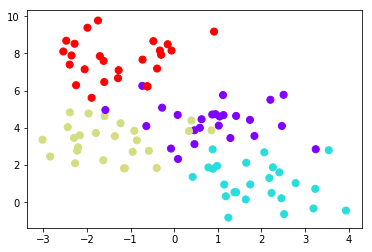

In [551]:
https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html

from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [558]:
X

amp     decay  periods
0     2.020787  0.357654       14
1    18.657350  0.027312       13
2    28.486321  0.076750       13
3    29.601497  0.068146       12
4    32.908656  0.083001       13
5    33.580086  0.091634       13
6    33.400271  0.097662       15
7    31.574884  0.090812        7
8   102.007148  0.093639       20
9    90.207128  0.092977       23
10   88.078419  0.107418       32
11   79.529105  0.122426       52
12   42.172399  0.022008       22
13   79.552372  0.052118       16
14  104.528100  0.050745       12
15  128.727736  0.081642       14
16  133.399350  0.072507        9
17   26.999424  0.065163       13
18   32.726914  0.072728       37
19   76.298171  0.029822        6
20  112.752541  0.050273       11
21  104.085403  0.064078       17
22   71.303146  0.047301       16
23   24.640280  0.073627       12
24   78.956605  0.003674       13
25  138.585479  0.042959       15
26  160.258661  0.055729       10
27   21.561409  0.095519       22
28   21.949964  0.093986       26
29   21.322797  0.086482       23
30   22.389210  0.099620       29
31   19.926287  0.087508       25
32   20.836090  0.090690       26
33   20.853419  0.094218       28
34   20.281684  0.090202       27
35   20.504680  0.084624       23
36   21.874439  0.096785       27
37   22.383298  0.098532       28
38   19.269903  0.099379       16
39    3.283752  0.106452       39
40  649.378018  0.253810       23
41  383.561042  0.242375       39
42  250.794381  0.238677       46
43  426.972647  0.245024       39
44   93.909304  0.190807       37
45  434.102815  0.242035       78
46  392.934496  0.245545       39
47  114.820746  0.213777       39
48  446.557996  0.252874       21

In [580]:
from sklearn.model_selection import cross_val_predict, cross_validate,cross_val_score

In [569]:
cross_val_predict == cross_validate

False

In [572]:
predict = cross_val_predict(rfc, X, y,cv=5)
print("RF accuracy: {:.1%}".format(np.mean(predict == y)))

RF accuracy: 69.4%


In [573]:
## http://localhost:8888/notebooks/Documents/Ex_Files_Machine_Learning_Algorithms/Ex_Files_Machine_Learning_Algorithms/Exercise%20Files/05_RF/05_04/End/05_04.ipynb

from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [574]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [575]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(X,y)

print_results(cv)

BEST PARAMS: {'max_depth': 8, 'n_estimators': 5}

0.653 (+/-0.205) for {'max_depth': 2, 'n_estimators': 5}
0.612 (+/-0.259) for {'max_depth': 2, 'n_estimators': 50}
0.592 (+/-0.29) for {'max_depth': 2, 'n_estimators': 250}
0.673 (+/-0.228) for {'max_depth': 4, 'n_estimators': 5}
0.653 (+/-0.28) for {'max_depth': 4, 'n_estimators': 50}
0.714 (+/-0.146) for {'max_depth': 4, 'n_estimators': 250}
0.755 (+/-0.391) for {'max_depth': 8, 'n_estimators': 5}
0.653 (+/-0.28) for {'max_depth': 8, 'n_estimators': 50}
0.694 (+/-0.191) for {'max_depth': 8, 'n_estimators': 250}
0.694 (+/-0.285) for {'max_depth': 16, 'n_estimators': 5}
0.694 (+/-0.191) for {'max_depth': 16, 'n_estimators': 50}
0.673 (+/-0.228) for {'max_depth': 16, 'n_estimators': 250}
0.673 (+/-0.174) for {'max_depth': 32, 'n_estimators': 5}
0.694 (+/-0.191) for {'max_depth': 32, 'n_estimators': 50}
0.673 (+/-0.228) for {'max_depth': 32, 'n_estimators': 250}
0.694 (+/-0.241) for {'max_depth': None, 'n_estimators': 5}
0.694 (+/-0.191) 

In [578]:
#https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652

from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth
}
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X, y)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


{'n_estimators': 800, 'max_features': 'sqrt', 'max_depth': 260}


In [581]:
rfc = RandomForestClassifier(n_estimators=800, max_depth=260, max_features='sqrt')
rfc.fit(X,y)
rfc_predict = rfc.predict(x2_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(df2t['src'], rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(df2t['src'], rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

ValueError: multiclass format is not supported

In [582]:
x2_test

a         b  periods
0    2.020787  0.238037       14
1   18.657350  0.018178       13
2   28.486321  0.051081       13
3   29.601497  0.045355       12
4   32.908656  0.055241       13
5   33.580086  0.060987       13
6   33.400271  0.064999       15
7   31.320741  0.054016       13
8   32.655432  0.060739       15
9   34.063519  0.056084       11
10  33.030143  0.046309       11
11  35.747946  0.063646       13
12  33.747756  0.086397       36
13  20.312566  0.109893        8

## Bar Charts in Matplotlib https://benalexkeen.com/bar-charts-in-matplotlib/

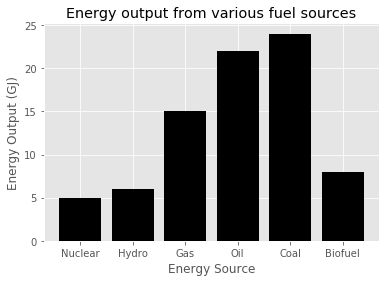

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['Nuclear', 'Hydro', 'Gas', 'Oil', 'Coal', 'Biofuel']
energy = [5, 6, 15, 22, 24, 8]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy, color='black')
plt.xlabel("Energy Source")
plt.ylabel("Energy Output (GJ)")
plt.title("Energy output from various fuel sources")

plt.xticks(x_pos, x)

plt.show()

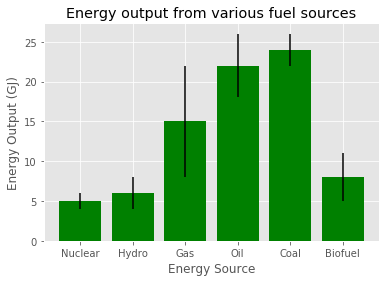

In [584]:
x = ['Nuclear', 'Hydro', 'Gas', 'Oil', 'Coal', 'Biofuel']
energy = [5, 6, 15, 22, 24, 8]
variance = [1, 2, 7, 4, 2, 3]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy, color='green', yerr=variance)
plt.xlabel("Energy Source")
plt.ylabel("Energy Output (GJ)")
plt.title("Energy output from various fuel sources")

plt.xticks(x_pos, x)

plt.show()

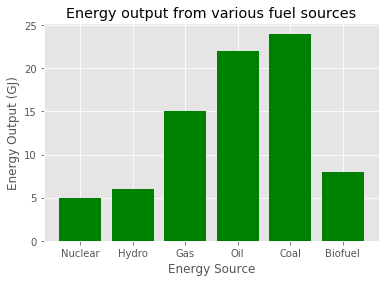

In [616]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['Nuclear', 'Hydro', 'Gas', 'Oil', 'Coal', 'Biofuel']
energy = [5, 6, 15, 22, 24, 8]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy, color='green')
plt.xlabel("Energy Source")
plt.ylabel("Energy Output (GJ)")
plt.title("Energy output from various fuel sources")

plt.xticks(x_pos, x)

plt.show()

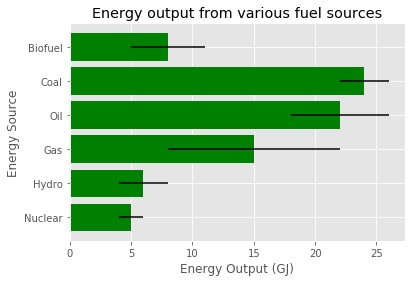

In [588]:
x = ['Nuclear', 'Hydro', 'Gas', 'Oil', 'Coal', 'Biofuel']
energy = [5, 6, 15, 22, 24, 8]
variance = [1, 2, 7, 4, 2, 3]

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, energy, color='green', xerr=variance)
plt.ylabel("Energy Source")
plt.xlabel("Energy Output (GJ)")
plt.title("Energy output from various fuel sources")

plt.yticks(x_pos, x)

plt.show()

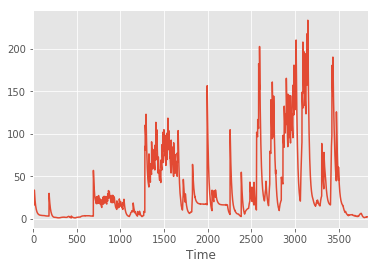

In [589]:
df['3_state'].plot()

In [590]:
0.8*len(df)

3070.4

In [591]:
0.2*len(df)

767.6

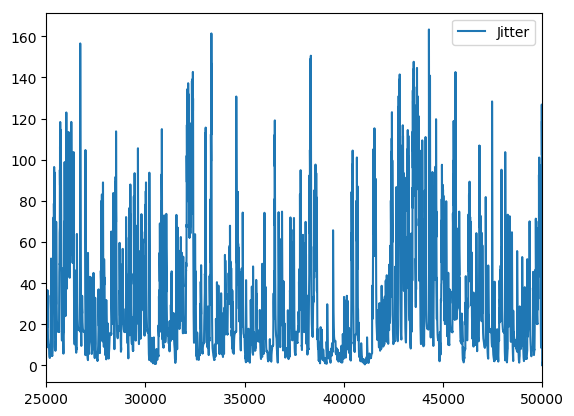

In [607]:
df3_state[25000:50000].plot()

In [613]:
df3_state[25000:50000].median()

Jitter    17.69265
dtype: float64

In [609]:
df3_state.mean()

Jitter    33.994004
dtype: float64

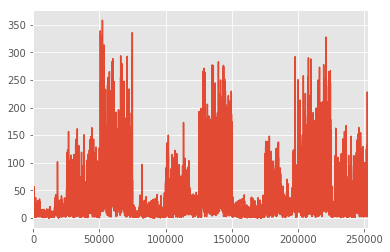

In [641]:
df3_state['Jitter'].plot()

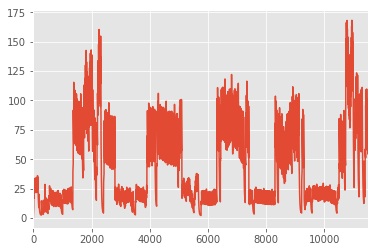

In [594]:
df2_state['Jitter'].plot()

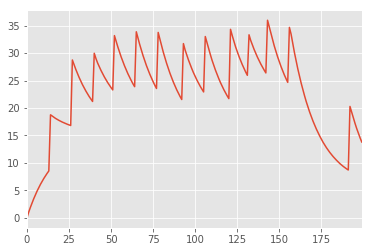

In [617]:
dfconstant['Jitter'][:200].plot()

In [618]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


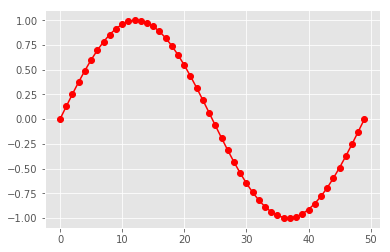

In [631]:
with plt.style.context('tableau-colorblind10'):
    plt.plot(np.sin(np.linspace(0, 2 * np.pi)), 'r-o')
plt.show()

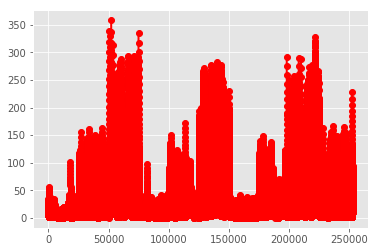

In [634]:
with plt.style.context('ggplot'):
    plt.plot(df3_state['Jitter'][, 'r-o')
plt.show()

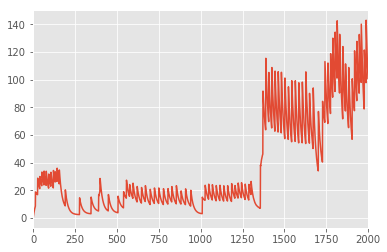

In [635]:
df2_state['Jitter'][:2000].plot()

In [638]:
df2_state['Jitter'][1350:1400].values

array([  7.45581143,   7.26707322,   7.30303739,   7.05634755,
         7.22220083,   7.02640703,   7.23294409,  38.11416633,
        37.60106219,  38.59827705,  39.52388474,  40.49992319,
        41.29233424,  42.0205946 ,  42.66255744,  43.24049135,
        43.83827314,  44.47069357,  44.88808772,  45.41270724,
        45.91606928,  46.23887745,  91.74407261,  89.35681806,
        86.95901696,  84.54939089,  82.1601477 ,  80.02654475,
        78.11994816,  76.14601394,  74.37648182,  72.79770168,
        71.13928284,  69.67620266,  68.29356501,  67.0994672 ,
        65.87171924,  64.77751805,  63.76464189, 115.463008  ,
       111.1658513 , 106.9339231 , 103.3450841 ,  99.80082887,
        96.47499582,  93.42308984,  90.43680299,  87.70325279,
        85.19708075,  82.77863819])

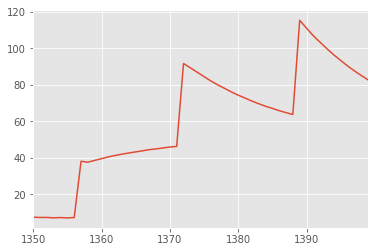

In [639]:
df2_state['Jitter'][1350:1400].plot()

In [640]:
df['const_j'].max()

37.87524264

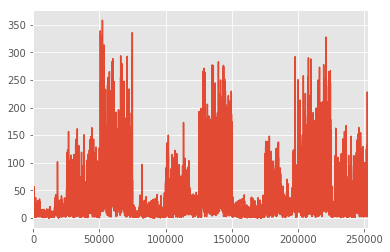

In [646]:
df3_state['Jitter'].plot()

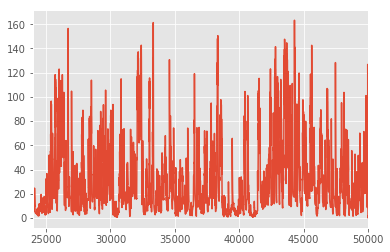

In [652]:
df3_state['Jitter'][24000:50000].plot()

In [662]:
df3_state['Jitter'][:23000].values.min()

0.194769888

In [663]:
df3_state['Jitter'][25000:50000].values.min()

0.0

In [672]:
df3_state['Jitter'][25000:49990].values.min()

0.560355452

In [660]:
df3_state['Jitter'][50000:75000].values.min()

1.293379632

In [664]:
np.where(df3_state['Jitter'][25000:50000].values == 0.0)

(array([24998], dtype=int64),)

In [671]:
df3_state['Jitter'][49990:50000]

49990    104.606791
49991    101.493978
49992     98.593965
49993     95.894954
49994     93.343630
49995     90.936514
49996    124.739121
49997    120.123037
49998      0.000000
49999      1.212778
Name: Jitter, dtype: float64

In [668]:
25000+24998

49998

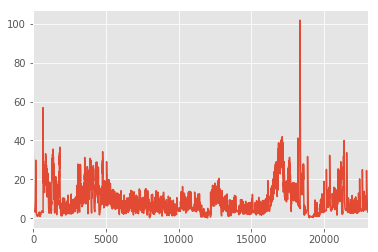

In [673]:
df3_state['Jitter'][:23000].plot()

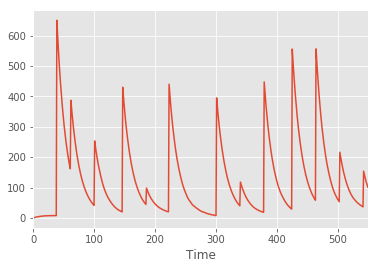

In [675]:
df['df264_hc'][:550].plot()

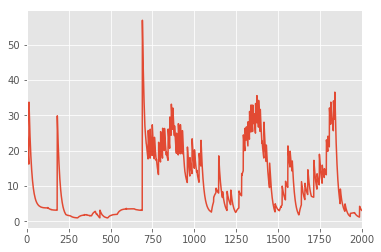

In [681]:
df3_state['Jitter'][:2000].plot()

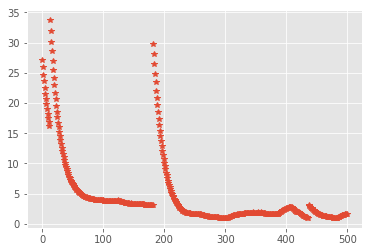

In [692]:
plt.plot(df3_state['Jitter'][:500], '*')

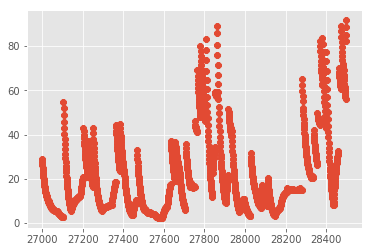

In [712]:
plt.plot(df3_state['Jitter'][27000:28500],'8')

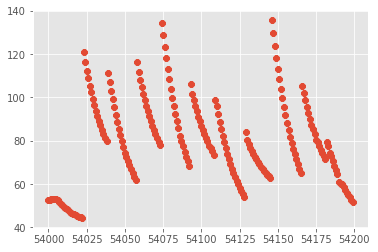

In [701]:
plt.plot(df3_state['Jitter'][54000:54200],'8')

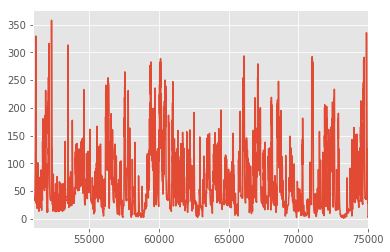

In [707]:
df3_state['Jitter'][51000:75000].plot()

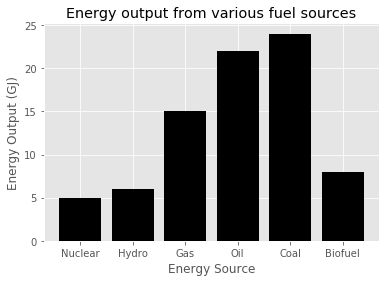

In [10]:
#import matplotlib.pyplot as plt
#%matplotlib inline
with plt.style.context('ggplot'):

#with plt.style.couse('ggplot')

    x = ['Nuclear', 'Hydro', 'Gas', 'Oil', 'Coal', 'Biofuel']
    energy = [5, 6, 15, 22, 24, 8]

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, energy, color='black')
    plt.xlabel("Energy Source")
    plt.ylabel("Energy Output (GJ)")
    plt.title("Energy output from various fuel sources")

    plt.xticks(x_pos, x);